# $SU(2)$ Benchmarking

$SU(2)$ benchmarking is a QCVV routine that can measure the two qubit gate fidelity independently
of any additional single qubit gate errors. To demonstrate this, we define a noise model which
applies single qubit bit-flip errors and two qubit depolarising errors.

In [1]:
import cirq

In [2]:
class IndependentNoiseModel(cirq.NoiseModel):
    "Applies single and two qubit noise channels independently"

    def __init__(self, single_qubit_error: float, two_qubit_error: float) -> None:
        super().__init__()
        self.single_qubit_error = single_qubit_error
        self.two_qubit_error = two_qubit_error
        self.single_qubit_error_channel = cirq.BitFlipChannel(p=single_qubit_error)
        self.two_qubit_error_channel = cirq.DepolarizingChannel(
            p=15 / 16 * two_qubit_error, n_qubits=2
        )

    def noisy_operation(self, operation: cirq.Operation) -> list[cirq.OP_TREE]:
        if len(operation.qubits) == 1:
            return [operation, self.single_qubit_error_channel(*operation.qubits)]
        if len(operation.qubits) == 2:
            return [operation, self.two_qubit_error_channel(*operation.qubits)]
        return [operation]


TWO_QUBIT_ERROR = 0.02
SINGLE_QUBIT_ERROR = 0.005
noise = IndependentNoiseModel(
    single_qubit_error=SINGLE_QUBIT_ERROR, two_qubit_error=TWO_QUBIT_ERROR
)
simulator = cirq.DensityMatrixSimulator(noise=noise)

We now run the experiment for a CNOT gate

Building circuits:   0%|          | 0/80 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/80 [00:00<?, ?it/s]

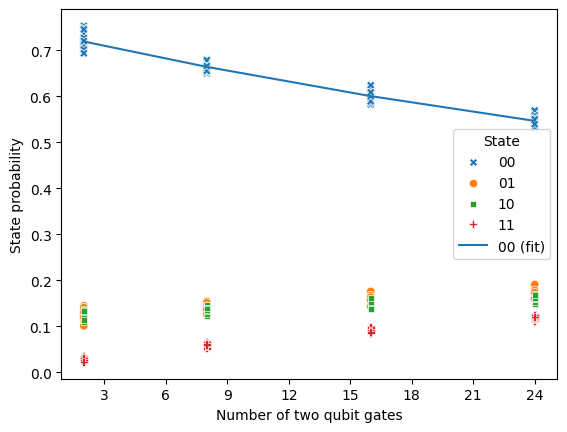

In [99]:
from supermarq.qcvv import SU2

experiment = SU2(two_qubit_gate=cirq.CNOT)
experiment.run_with_simulator(20, [1, 4, 8, 12], simulator=simulator)
if experiment.collect_data():
    result = experiment.analyse_results()

If we then compare the output results we see that the experiment has accurately estimated 
the two qubit gate error.

In [100]:
print(
    f"Estimated two qubit gate error: {result.two_qubit_gate_error:.4f} +/ {result.two_qubit_gate_error_std:.4f}"
)
print(f"True two qubit gate error: {TWO_QUBIT_ERROR:.4f}")

Estimated two qubit gate error: 0.0206 +/ 0.0004
True two qubit gate error: 0.0200
